# Group 12 - Strategy Implementation and Backtesting

## 0. Import packages

If there are any missing packages, you can install them by typing in the code shell:
```terminal
!pip install <package_name>
```
or
```terminal
%pip install <package_name>
```

In [ ]:
import pandas as pd
import numpy as np
import psycopg
import json
import pprint
import mplfinance as mpf

from typing import List
from matplotlib import pyplot as plt
from numpy.testing import assert_almost_equal, assert_equal

## 1. Data Preparation
### 1.1. Data Importing
First, we load the data from `yfinance`:

In [171]:
# Load data
with open('database.json', 'rb') as fb:
    db_info = json.load(fb)
conn = psycopg.connect(
    host=db_info['host'],
    port=db_info['port'],
    dbname=db_info['database'],
    user=db_info['user'],
    password=db_info['password']
)
with psycopg.connect(
    host=db_info['host'],
    port=db_info['port'],
    dbname=db_info['database'],
    user=db_info['user'],
    password=db_info['password']
) as conn:
    # Open a cursor to perform database operations
    with conn.cursor() as data:
        
        # Execute a query
        data.execute("""
            SELECT m.datetime, m.tickersymbol, m.price
            FROM "quote"."matched" m
            WHERE m.tickersymbol LIKE 'VN30F23%'
            and m.datetime >= '2023-01-01 00:00:00'
        """)

        # Use fetchall() to get all the data of the query.
        # Note: fetchall() can be costly and inefficient.
        # Other efficient ways have been discussed extensively on the Internet. Or you can ask ChatGPT ;)
        dataset = data.fetchall()

        # Print the total number of ticks of that day
        print(f'Total number of tick: {len(dataset)}')

        # Pretty print the first five ticks

Total number of tick: 852871


float64
                           tickersymbol   price
datetime                                       
2023-01-03 08:53:35.786065    VN30F2301  1003.9
2023-01-03 08:53:38.830273    VN30F2301  1003.0
2023-01-03 08:53:43.123991    VN30F2301  1001.5
2023-01-03 08:53:44.955494    VN30F2301   999.9
2023-01-03 08:53:49.229305    VN30F2301   998.0
2023-01-03 08:53:58.581899    VN30F2301   996.0
2023-01-03 08:54:02.693682    VN30F2301   995.0
2023-01-03 08:54:08.757904    VN30F2301   996.0
2023-01-03 08:54:10.811583    VN30F2301   995.0
2023-01-03 08:54:21.996896    VN30F2301   994.0
2023-01-03 08:54:23.014076    VN30F2301   994.1
2023-01-03 08:54:25.246076    VN30F2301   994.0
2023-01-03 08:54:33.600425    VN30F2301   995.0
2023-01-03 08:54:55.419529    VN30F2301   995.1
2023-01-03 08:54:57.237656    VN30F2301   996.0
2023-01-03 08:54:59.289493    VN30F2301   995.0
2023-01-03 08:55:55.097055    VN30F2301   998.0
2023-01-03 08:56:09.359869    VN30F2302  1003.0
2023-01-03 08:56:33.203164    VN

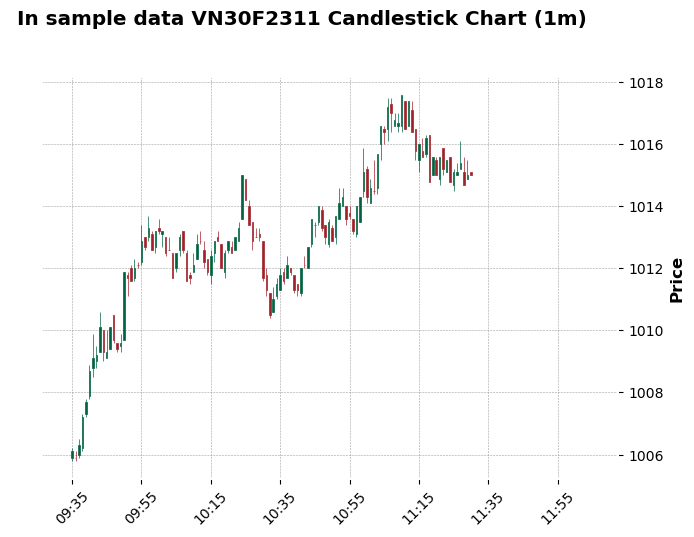

float64
557800 2
                    tickersymbol    open    high     low   close
datetime                                                        
2023-01-03 08:45:00    VN30F2301   983.0   984.2   934.2   939.0
2023-01-03 08:46:00    VN30F2301   940.0   941.0   940.0   941.0
2023-01-03 08:47:00    VN30F2301   941.8   989.0   941.8   989.0
2023-01-03 08:48:00    VN30F2301   985.0   993.1   985.0   993.1
2023-01-03 08:49:00    VN30F2301   994.0   995.0   994.0   995.0
2023-01-03 08:50:00    VN30F2301   996.0  1000.0   996.0   999.7
2023-01-03 08:51:00    VN30F2301   999.9  1000.1   999.9  1000.1
2023-01-03 08:52:00    VN30F2301   999.6   999.7   998.5   999.7
2023-01-03 08:53:00    VN30F2301   999.9  1004.4   996.0   996.0
2023-01-03 08:54:00    VN30F2301   995.0   996.0   994.0   995.0
2023-01-03 08:55:00    VN30F2301   998.0   998.0   998.0   998.0
2023-01-03 08:56:00    VN30F2301   997.9   997.9   996.0   996.0
2023-01-03 08:57:00    VN30F2301   997.0   998.0   996.0   997.9
2023-01-

In [305]:
# Devide data into in-sample and out-sample
in_sample_dataset = dataset[:int(len(dataset)*0.7)]
out_sample_dataset = dataset[int(len(dataset)*0.3):]

# Chuyển dữ liệu sang DataFrame của in_sample_data
in_sample_candle = pd.DataFrame(in_sample_dataset, columns=['datetime', 'tickersymbol', 'price'])
in_sample_candle['price'] = pd.to_numeric(in_sample_candle['price'], errors='coerce')
print(in_sample_candle['price'].dtype)

# Chuyển đổi cột datetime về kiểu datetime
in_sample_candle['datetime'] = pd.to_datetime(in_sample_candle['datetime'])
in_sample_candle.set_index('datetime', inplace=True)
in_sample_candle['ticker_month'] = in_sample_candle['tickersymbol'].str[-2:].astype(int)

# Create a boolean mask: keep rows if ticker_month <= (datetime month + 1)
mask = in_sample_candle['ticker_month'] <= (in_sample_candle.index.month + 1)

# Filter the DataFrame using the mask
in_sample_candle = in_sample_candle[mask]

# (Optional) Remove the temporary column if no longer needed
in_sample_candle.drop(columns='ticker_month', inplace=True)

# Sort by datetime
in_sample_candle.sort_index(inplace=True)


print(in_sample_candle[50:100])

# Resample dữ liệu theo khung 1 giờ (1h)
in_sample_candle_ohlc = in_sample_candle['price'].resample('1T').ohlc()
in_sample_candle_ohlc = (
    in_sample_candle
    .groupby('tickersymbol')
    .resample('1T')['price']
    .ohlc()
    .reset_index()
)
in_sample_candle_ohlc.set_index('datetime', inplace=True)

# Vẽ biểu đồ nến
mpf.plot(in_sample_candle_ohlc[50:200], type='candle', style='charles',
        title=" In sample data VN30F2311 Candlestick Chart (1m)", ylabel="Price")

# Chuyển dữ liệu sang DataFrame của in_sample_data
out_sample_candle = pd.DataFrame(out_sample_dataset[0:50], columns=['datetime', 'tickersymbol', 'price'])
out_sample_candle['price'] = pd.to_numeric(out_sample_candle['price'], errors='coerce')
print(out_sample_candle['price'].dtype)
# Chuyển đổi cột datetime về kiểu datetime
out_sample_candle['datetime'] = pd.to_datetime(out_sample_candle['datetime'])
out_sample_candle.set_index('datetime', inplace=True)

# Resample dữ liệu theo khung 1 giờ (1h)
out_sample_candle_ohlc = out_sample_candle['price'].resample('5t').ohlc()


# Vẽ biểu đồ nến
# mpf.plot(out_sample_candle_ohlc[-50:], type='candle', volume=True, style='charles',
#         title=" Out sample data VN30F2311 Candlestick Chart (1h)", ylabel="Price", ylabel_lower="Volume")

print(len(in_sample_candle_ohlc), len(out_sample_candle_ohlc))
print(in_sample_candle_ohlc[0:50])
print(out_sample_candle_ohlc[-10:])

## 2. Trading Algorithm & Backtesting

In [314]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Constants ---
multiplier = 100000
margin_ratio = 0.175
AR = 0.8
fee_points = 0.47

# Initialize asset variables
total_asset = 100_000_000  # Total asset in VND
available_asset = total_asset  # Funds available for trading

# --- Prepare Data ---
# Assume in_sample_candle_ohlc is a DataFrame with a DateTimeIndex.
df = in_sample_candle_ohlc.copy()
df['SMA50'] = df['close'].rolling(window=50, min_periods=50).mean()

# Reset the index so that the datetime becomes a column.
df.reset_index(inplace=True)
df.rename(columns={'index': 'datetime'}, inplace=True)

# Convert DataFrame to list of dictionaries for faster common indexing
df_list = df.to_dict('records')

# --- Trade State ---
open_positions = []  # List of currently open positions
trades = []          # List to record completed trades

def open_position(position_type, entry_price, entry_time):
    global available_asset
    deposit = (entry_price * multiplier * margin_ratio) / AR
    if available_asset < deposit:
        print(f"Insufficient funds to open {position_type} trade at {entry_time}. Required deposit: {deposit}, available: {available_asset}")
        return
    available_asset -= deposit  # Lock the deposit
    new_position = {
        'type': position_type,  # 'long' or 'short'
        'entry_price': entry_price,
        'entry_time': entry_time,
        'deposit': deposit
    }
    open_positions.append(new_position)
    print(f"Opened {position_type} position at {entry_price} on {entry_time} with deposit {deposit}")

def close_position(position, exit_price, exit_time):
    global available_asset, total_asset
    entry_price = position['entry_price']
    deposit = position['deposit']
    if position['type'] == 'long':
        raw_points = exit_price - entry_price
    else:  # For a short position:
        raw_points = entry_price - exit_price
    net_points = raw_points - fee_points
    profit_vnd = net_points * multiplier
    available_asset += deposit + profit_vnd  # Return deposit and profit
    total_asset += profit_vnd  # Update overall asset value
    # Record the trade details.
    trade = position.copy()
    trade['exit_price'] = exit_price
    trade['exit_time'] = exit_time
    trade['raw_points'] = raw_points
    trade['net_points'] = net_points
    trade['profit_vnd'] = profit_vnd
    trade['profit_pct'] = profit_vnd / deposit
    if pd.isna(exit_time):
        return
    trades.append(trade)
    print(f"Closed {position['type']} position opened on {position['entry_time']} at {exit_price} on {exit_time} with profit {profit_vnd} VND, return {trade['profit_pct']*100:.2f}%")

def close_all_positions(exit_price, exit_time):
    # Close each open position.
    for pos in open_positions.copy():
        close_position(pos, exit_price, exit_time)
        open_positions.remove(pos)

In [315]:


# --- Backtesting Loop Using df_list ---
n = len(df_list)
for i in range(n):
    current_candle = df_list[i]
    current_time = current_candle['datetime']
    
    # --- Overnight Position Closing ---
    if i > 0:
        prev_time = df_list[i-1]['datetime']
        if current_time.date() != prev_time.date():
            # Close all open positions at the previous candle's close.
            close_all_positions(df_list[i-1]['close'], prev_time)
    
    # --- Check Exit Conditions for Each Open Position ---
    for pos in open_positions.copy():
        if pos['type'] == 'long':
            unrealized_points = current_candle['close'] - pos['entry_price']
        else:
            unrealized_points = pos['entry_price'] - current_candle['close']
        # Exit if take profit (>= 3 points) or stop loss (<= -1 point) is reached.
        if unrealized_points >= 3 or unrealized_points <= -1:
            close_position(pos, current_candle['close'], current_time)
            open_positions.remove(pos)
    
    # --- Check for Entry Signals ---
    if i >= 3:
        # Check if the previous 3 candles are consecutive (1 minute apart)
        if ((current_time - df_list[i-1]['datetime'] == pd.Timedelta(minutes=1)) and
            (df_list[i-1]['datetime'] - df_list[i-2]['datetime'] == pd.Timedelta(minutes=1)) and
            (df_list[i-2]['datetime'] - df_list[i-3]['datetime'] == pd.Timedelta(minutes=1)) and
            (current_candle['tickersymbol'] == df_list[i-1]['tickersymbol'] ==
             df_list[i-2]['tickersymbol'] == df_list[i-3]['tickersymbol'])):
            
            # Get the previous three candles
            prev_candles = df_list[i-3:i]
            # Define patterns: bearish if close < open, bullish if close > open.
            bearish_pattern = all(candle['close'] < candle['open'] for candle in prev_candles)
            bullish_pattern = all(candle['close'] > candle['open'] for candle in prev_candles)
            # Ensure SMA50 is available.
            if np.isnan(current_candle['SMA50']):
                continue
            
            # Entry Signal for LONG: previous 3 candles are bearish, previous candle’s high is below current candle’s close,
            # and current candle’s close is above its SMA50.
            if bearish_pattern and (df_list[i-1]['high'] < current_candle['close']) and (current_candle['SMA50'] < current_candle['close']):
                open_position('long', current_candle['close'], current_time)
            # Entry Signal for SHORT can be added similarly if desired.
            if bullish_pattern and (df_list[i-1]['low'] > current_candle['close']) and (current_candle['SMA50'] > current_candle['close']):
                open_position('short', current_candle['close'], current_time)
    
# --- End of Backtesting Loop ---
if open_positions:
    close_all_positions(df_list[-1]['close'], df_list[-1]['datetime'])

# --- Trade Summary ---
trades_df = pd.DataFrame(trades)
print("\nBacktesting completed. Trade summary:")
print(trades_df)
total_profit = trades_df['profit_vnd'].sum() if not trades_df.empty else 0
print(f"Total Profit: {total_profit} VND")


Opened long position at 1012.1 on 2023-01-03 10:10:00 with deposit 22139687.5
Closed long position opened on 2023-01-03 10:10:00 at 1010.5 on 2023-01-03 10:32:00 with profit -207000.00000000224 VND, return -0.93%
Opened long position at 1014.0 on 2023-01-03 10:57:00 with deposit 22181250.0
Closed long position opened on 2023-01-03 10:57:00 at 1017.2 on 2023-01-03 11:06:00 with profit 273000.0000000046 VND, return 1.23%
Opened short position at 1014.7 on 2023-01-03 11:28:00 with deposit 22196562.5
Closed short position opened on 2023-01-03 11:28:00 at 1016.2 on 2023-01-03 13:00:00 with profit -197000.0 VND, return -0.89%
Opened long position at 1029.5 on 2023-01-03 14:17:00 with deposit 22520312.5
Opened short position at 1028.8 on 2023-01-03 14:20:00 with deposit 22505000.0
Closed long position opened on 2023-01-03 14:17:00 at 1026.8 on 2023-01-03 14:21:00 with profit -317000.00000000454 VND, return -1.41%
Closed short position opened on 2023-01-03 14:20:00 at 1032.5 on 2023-01-03 14:2

In [316]:

print(f"Total profit: {total_profit:.2f} VND")
print(f"Final total asset: {total_asset:.2f} VND")

Total profit: -19255000.00 VND
Final total asset: nan VND


## 4. Evaluation

### 4.1 Asset Over Time
Asset over time is a simple and intuitive way to show if the algorithm works. If your asset increased, you're doing something right and vice versa. Just simply record the asset through the period of trading, here is the period of backtesting and plot it.

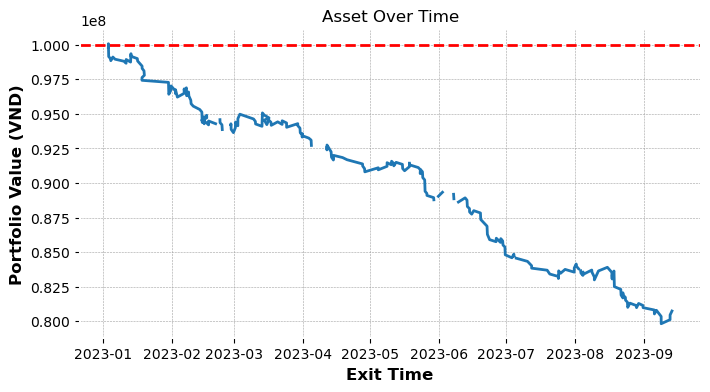

In [ ]:
import matplotlib.pyplot as plt

# Set initial capital (must be consistent with your simulation)
initial_capital = 100_000_000  # VND

# Convert trades into a DataFrame (assuming the list "trades" is already available)
trades_df = pd.DataFrame(trades)

# Ensure trades are sorted by exit time
trades_df.sort_values(by="exit_time", inplace=True)

# Compute cumulative asset value over time
trades_df["capital_over_time"] = initial_capital + trades_df["profit_vnd"].cumsum()
trades_df["capital_over_time"] = trades_df["capital_over_time"].ffill()

# Plot the asset curve (capital over time)
plt.figure(figsize=(8, 4))
plt.plot(trades_df["exit_time"], trades_df["capital_over_time"], label="Portfolio Value")
plt.axhline(y=initial_capital, color="r", linestyle="--", label="Initial Capital")
plt.title('Asset Over Time')
plt.xlabel("Exit Time")
plt.ylabel("Portfolio Value (VND)")
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()


### 4.2 Holding Period Return

We can also calculate the rate of return during the considered period

In [302]:
# Example initial capital matching your simulation
initial_capital = 100_000_000

# Convert trades into a DataFrame if needed
trades_df = pd.DataFrame(trades)

# Sum of profits from all trades
total_profit = trades_df["profit_vnd"].sum() if not trades_df.empty else 0

# Compute final capital
final_capital = initial_capital + total_profit

# Compute Holding Period Return
HPR = ((final_capital - initial_capital) / initial_capital) * 100

print(f"Initial Capital: {initial_capital} VND")
print(f"Final Capital: {final_capital} VND")
print(f"Holding Period Return (HPR): {HPR:.2f}%")


Initial Capital: 100000000 VND
Final Capital: 78659000.0 VND
Holding Period Return (HPR): -21.34%


### 4.3 Maximum Drawdown (MDD)

Maximum Drawdown (MDD) is also a great tool for assessing the maximum theoretical risk. We can calculate the MDD below.

In [303]:
import pandas as pd

# Example initial capital
initial_capital = 100_000_000

# Convert trades into a DataFrame if needed
trades_df = pd.DataFrame(trades)

# Sort by exit time to ensure chronological order
trades_df.sort_values(by="exit_time", inplace=True)

# Compute the capital over time by cumulatively adding profits
trades_df["capital_over_time"] = initial_capital + trades_df["profit_vnd"].cumsum()

# Calculate the running maximum (peak) of the portfolio
running_max = trades_df["capital_over_time"].cummax()

# Compute drawdown as the difference between the peak and the current capital
drawdown = running_max - trades_df["capital_over_time"]

# The maximum drawdown (MDD) is the largest drop from a peak
max_drawdown = drawdown.max()

# Convert to percentage by dividing by the maximum running peak
MDD_percentage = (max_drawdown / running_max.max()) * 100 if running_max.max() != 0 else 0

print(f"Maximum Drawdown (MDD): {MDD_percentage:.2f}%")


Maximum Drawdown (MDD): 21.39%


### 4.4 Sharpe ratio

We have shown that the `Sharpe Ratio` is also a great tool to evaluate the compromising between reward and risk. We show the `Sharpe Ratio` of the SMA Trading algorithm in this section.

In [304]:
if not trades:
    sharpe_ratio = "No trades executed, Sharpe Ratio cannot be calculated."
else:
    # Convert trade list to DataFrame
    trades_df = pd.DataFrame(trades)
    trades_df = trades_df.dropna(subset=["exit_time"]).copy()
    trades_df.sort_values(by="exit_time", inplace=True)
    trades_df.reset_index(drop=True, inplace=True)
    
    # Set initial capital (consistent with simulation)
    initial_capital = 100_000_000  # VND

    # Cumulative sum of all profits (in VND) up to each trade
    trades_df["cumulative_profit"] = trades_df["profit_vnd"].cumsum()

    # The portfolio's capital at each trade exit
    trades_df["capital"] = initial_capital + trades_df["cumulative_profit"]

    # Create a daily timestamp column (floor exit_time to date)
    trades_df["date"] = trades_df["exit_time"].dt.floor("D")
    
    # Get the last capital value for each day
    daily_equity = trades_df.groupby("date")["capital"].last()
    
    # Reindex to a daily date range and forward-fill missing days
    all_days = pd.date_range(start=daily_equity.index.min(),
                             end=daily_equity.index.max(),
                             freq="D")
    daily_equity = daily_equity.reindex(all_days, method="ffill")
    
    # Sharpe Ratio Calculation (daily-based)
    risk_free_rate_annual = 0.03  # 3% annual risk-free rate
    trading_days_per_year = 252
    daily_returns = daily_equity.pct_change().fillna(0)
    # Convert annual risk-free rate to daily
    daily_rf = risk_free_rate_annual / trading_days_per_year

    # Excess returns = daily returns minus the daily risk-free rate
    excess_returns = daily_returns - daily_rf

    mean_excess_return = excess_returns.mean()
    std_excess_return = excess_returns.std()

    sharpe_ratio = (mean_excess_return / std_excess_return) * np.sqrt(trading_days_per_year) \
        if std_excess_return != 0 else np.nan

    print("Daily-based Sharpe Ratio:", sharpe_ratio)


Daily-based Sharpe Ratio: -5.014770613156885
